# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2024-04-08 09:29:09--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: 'petfaces.tar.gz'

petfaces.tar.gz     100%[===================>]  23.35M   195KB/s    in 2m 6s   

2024-04-08 09:31:16 (190 KB/s) - 'petfaces.tar.gz' saved [24483412/24483412]



Для визуализации списка изображений можно использовать такую функцию:

In [153]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import warnings 
from torchvision import models, transforms

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch

from tqdm.notebook import tqdm
import pickle
warnings.filterwarnings('ignore')

def display_images(paths,titles=None,fontsize=12):
    n=len(paths)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(paths):
        image = Image.open(im)
        ax[i].imshow(image)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

## Посмотрим на данные

Определим pd.DataFrame, где будет хранится пути к изображениям и название файла изображения

In [154]:
main_path = "/kaggle/working/petfaces"
list_directory = os.listdir(main_path)

df = pd.DataFrame(columns = ["path", "target"])

for directory in list_directory:
    current_files = os.listdir(main_path+"/"+directory)
    temp_df = pd.DataFrame(data = {"path": [main_path +"/"+ directory +"/"+ name for name in current_files], "target": [directory for _ in range(len(current_files))]})
    df = pd.concat([df, temp_df])

In [155]:
df = df.sample(frac=1).reset_index(drop=True)
df

,path,target
0,/kaggle/working/petfaces/dog_german/german_sho...,dog_german
1,/kaggle/working/petfaces/cat_British/British_S...,cat_British
2,/kaggle/working/petfaces/cat_British/British_S...,cat_British
3,/kaggle/working/petfaces/cat_Maine/Maine_Coon_...,cat_Maine
4,/kaggle/working/petfaces/dog_american/american...,dog_american
...,...,...
3206,/kaggle/working/petfaces/dog_basset/basset_hou...,dog_basset
3207,/kaggle/working/petfaces/dog_japanese/japanese...,dog_japanese
3208,/kaggle/working/petfaces/dog_beagle/beagle_130...,dog_beagle
3209,/kaggle/working/petfaces/dog_pug/pug_122.jpg,dog_pug


Посмотрим на несколько фотографий

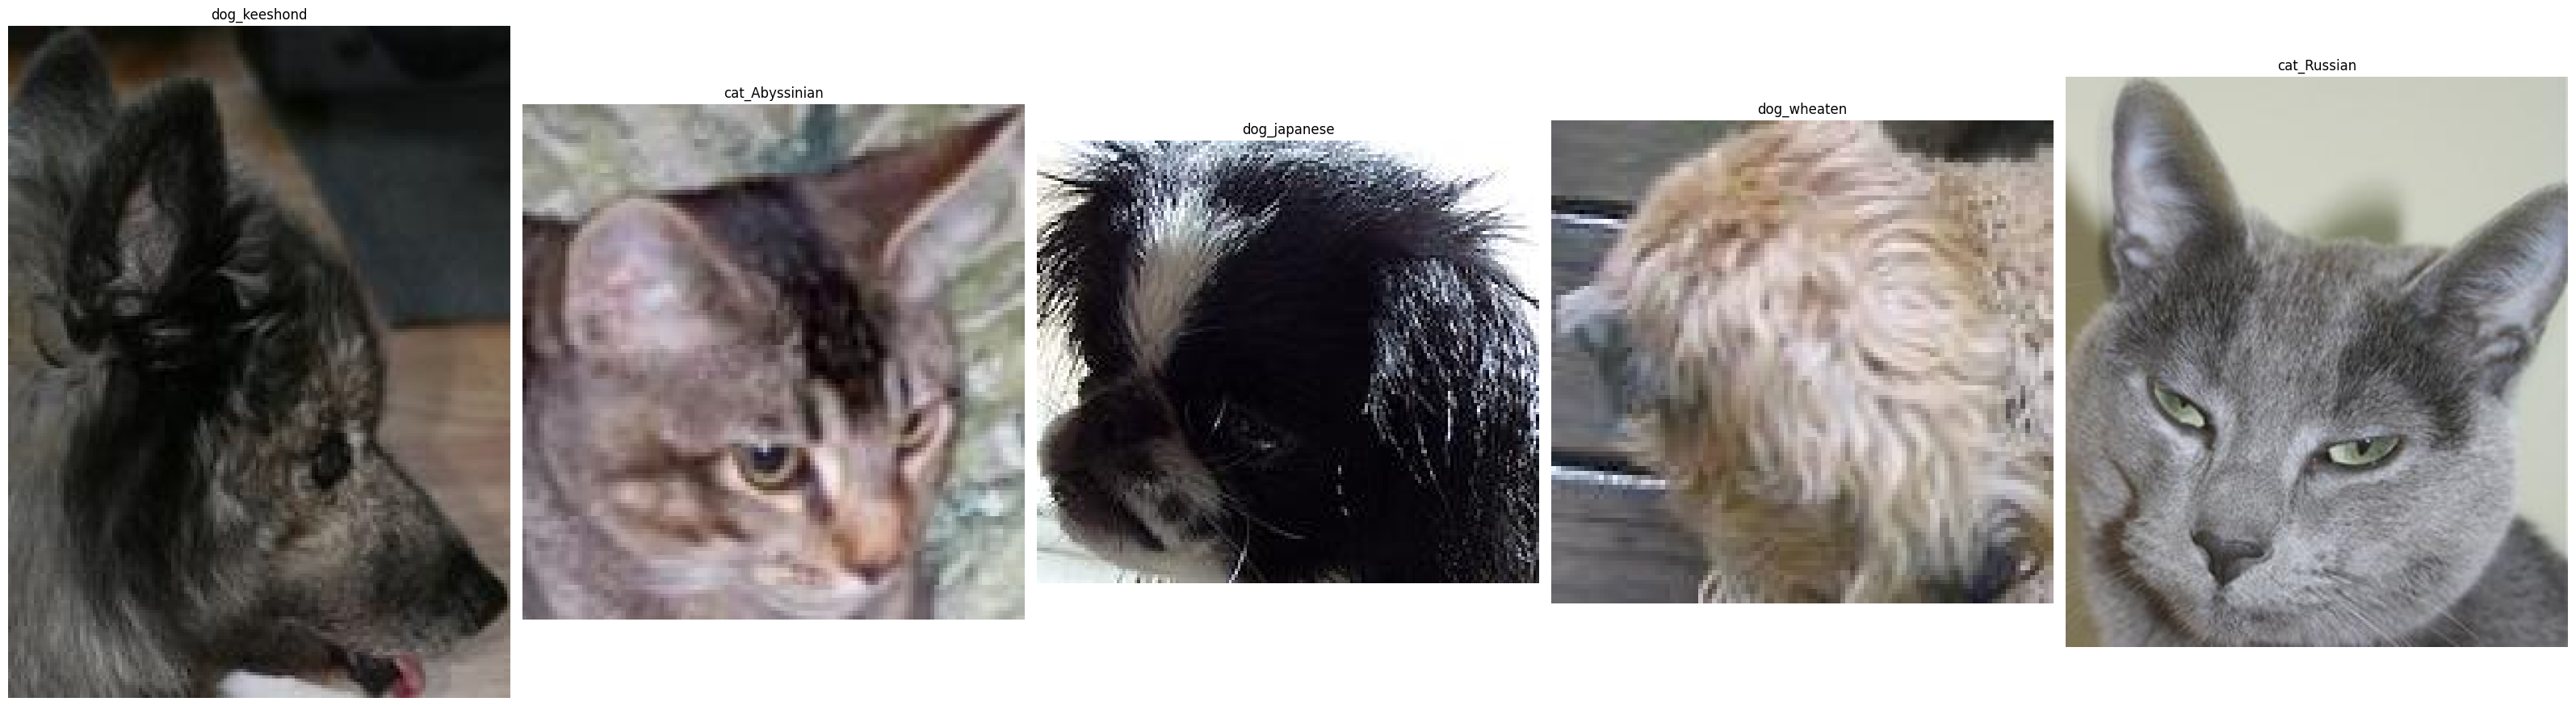

In [156]:
N = 5
samples_images = df.sample(N)
display_images(list(samples_images["path"]), list(samples_images["target"]))

Добавим колонки для определения семейства (Кошка/Собака) и колонка для вида

In [157]:
df["family"] = df["target"].apply(lambda name: name[:3])
df["form"] = df["target"].apply(lambda name: name[4:])

Посмотрим на распределение каждого из классов

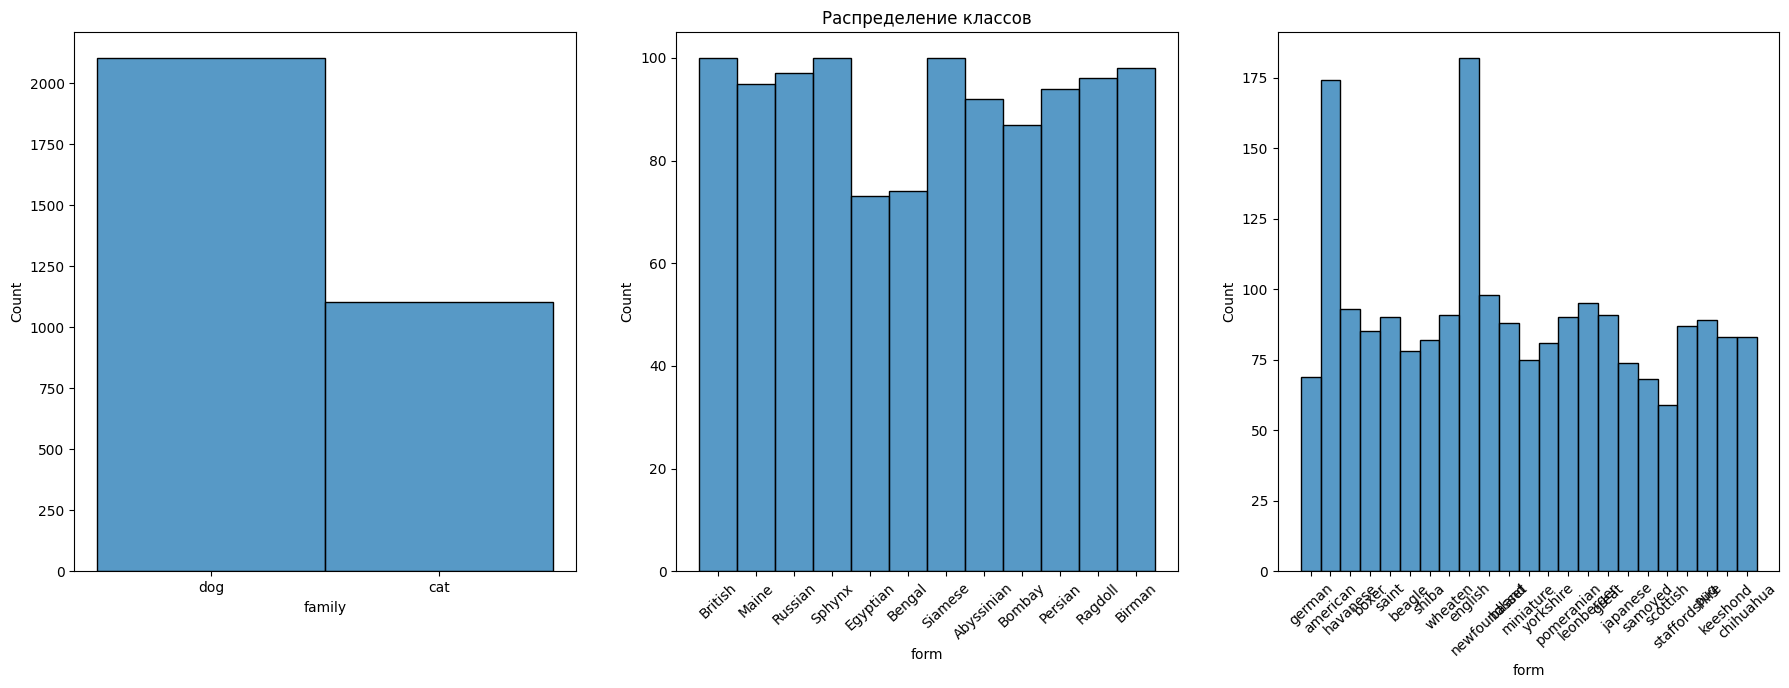

In [158]:
fig, axes = plt.subplots(1, 3, figsize = (22, 7))

sns.histplot(data = df, x = "family", ax = axes[0])
sns.histplot(data = df[df["family"] == "cat"], x = "form", ax = axes[1])
sns.histplot(data = df[df["family"] == "dog"], x = "form", ax = axes[2])

axes[1].set_title("Распределение классов")
axes[1].tick_params(axis = "x", labelrotation = 43)
axes[2].tick_params(axis = "x", labelrotation = 43)

Кошек в датасете меньше чем собак

## Определим класс, который подгружает из папки фотографии и производит преобразование изображений

In [159]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [160]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224


class DogCatDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, df, target, mode):
        super().__init__()

        self.files = list(df["path"])
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = list(df[target])
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == "train":
            augmentations = transforms.RandomChoice([
                                   transforms.Compose([
                                       transforms.Resize(size=313, max_size=333),
                                       transforms.CenterCrop(size=300),
                                       transforms.RandomCrop(250)
                                       ]),
                                   transforms.RandomRotation(degrees=(-33, 33)),
                                   transforms.RandomHorizontalFlip(p=1),
                                   ])
            transform = transforms.Compose([
                                    augmentations,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

        if self.files[index][-3:] == "png":
            x = Image.open(self.files[index])
            x = x.convert("RGB")
        else:
            x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x, self.files[index]
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y, self.files[index]

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Посмотрим, как выглядит картинка после преобразований

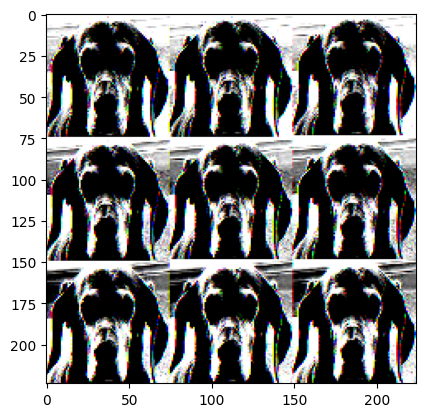

In [161]:
images = DogCatDataset(df, target = "family", mode = "train")
plt.imshow(np.reshape(images[0][0].numpy(), (224, 224, 3)))

## Общие функции для обучения

Определим функции для обучения, для эпохи обучение на трейне и эпохи обучения на тестовой выборке

In [162]:
def train_epoch(model, train_loader, criterion, optimizer, sheduler = None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for images, labels, _ in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(-1)
        running_loss += loss.item()*images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += images.size(0)
    if sheduler is not None:
        sheduler.step()
    loss_train = running_loss / processed_data
    acc_train = running_corrects.cpu().numpy() / processed_data
    
    return loss_train, acc_train

In [163]:
def val_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for images, labels, _ in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(-1)

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += images.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    return val_loss, val_acc

In [164]:
def train(model, train_loader, val_loader, criterion = None, optimizer = None, epochs = 20, sheduler = None):
    if optimizer is None:
          optimizer = torch.optim.Adam(model.parameters())

    if criterion is None:
          criterion = nn.CrossEntropyLoss()

    loss = {"train":[], "val":[]}
    accuracy = {"train":[], "val": []}
    
    best_accuracy = 0.0
    
    best_model_wts = model.state_dict()

    log_template = "\nEpoch {ep:03d}\t train_loss: {t_loss:0.4f}\t \
    val_loss {v_loss:0.4f}\t train_acc {t_acc:0.4f}\t val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            loss_train, accuracy_train = train_epoch(model, train_loader, criterion, optimizer, sheduler)
            loss["train"].append(loss_train)
            accuracy["train"].append(accuracy_train)

            loss_val, accuracy_val = val_epoch(model, val_loader, criterion)
            loss["val"].append(loss_val)
            accuracy["val"].append(accuracy_val)

            if accuracy_val > best_accuracy:
                best_accuracy = accuracy_val
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss_train,\
                                               v_loss=loss_val, t_acc=accuracy_train, v_acc=accuracy_val))
            

    print("best val Acc: {:4f}".format(best_accuracy))
    model.load_state_dict(best_model_wts)
            
    return model, loss, accuracy

## Задача бинарной классификации

Архитектура сети

In [165]:
class CatDogNet(nn.Module):
    def __init__(self, num_classes=2, hidden_dim = 8):
        super().__init__()

        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, kernel_size=7, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim,hidden_dim, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(hidden_dim*4, 64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        
        x = self.enc_conv0(x)
        x = self.enc_conv1(x)
        x = self.enc_conv2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        x = self.classifier(x)

        return x

Разделим наш датасет для задачи классификации семейства животного, с сохранением распределения

In [98]:
df_train, df_val = train_test_split(df, test_size = 0.15, stratify=df["family"])
print(df.shape)
print(df_train.shape)
print(df_val.shape)

(3211, 4)
(2729, 4)
(482, 4)


In [15]:
train_data = DogCatDataset(df_train, target = "family", mode = "train")
val_data = DogCatDataset(df_val, target = "family", mode = "val")


train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 128)

In [16]:
model = CatDogNet(hidden_dim = 42).to(DEVICE)
num_params = sum(p.numel() for p in model.parameters())
print(model)
print("\n Count parameters:", num_params)

CatDogNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 42, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(42, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv1): Sequential(
    (0): Conv2d(42, 84, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(84, 84, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv2): Sequential(
    (0): Conv

In [17]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model, loss, accuracy = train(model, train_loader, val_loader, epochs = 25, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 001	 train_loss: 0.5469	     val_loss 0.4891	 train_acc 0.7270	 val_acc 0.7822

Epoch 002	 train_loss: 0.3843	     val_loss 0.3488	 train_acc 0.8256	 val_acc 0.8589

Epoch 003	 train_loss: 0.3165	     val_loss 0.3028	 train_acc 0.8586	 val_acc 0.8859

Epoch 004	 train_loss: 0.2328	     val_loss 0.2512	 train_acc 0.9040	 val_acc 0.8963

Epoch 005	 train_loss: 0.2254	     val_loss 0.2864	 train_acc 0.9106	 val_acc 0.8817

Epoch 006	 train_loss: 0.1850	     val_loss 0.2312	 train_acc 0.9278	 val_acc 0.9087

Epoch 007	 train_loss: 0.1785	     val_loss 0.2181	 train_acc 0.9318	 val_acc 0.9212

Epoch 008	 train_loss: 0.1934	     val_loss 0.3240	 train_acc 0.9241	 val_acc 0.8672

Epoch 009	 train_loss: 0.1782	     val_loss 0.2133	 train_acc 0.9311	 val_acc 0.9170

Epoch 010	 train_loss: 0.1699	     val_loss 0.2927	 train_acc 0.9337	 val_acc 0.8755

Epoch 011	 train_loss: 0.1417	     val_loss 0.1793	 train_acc 0.9454	 val_acc 0.9378

Epoch 012	 train_loss: 0.1178	     val_loss 0.1716	 t

Text(0.5, 1.0, 'Accuracy')

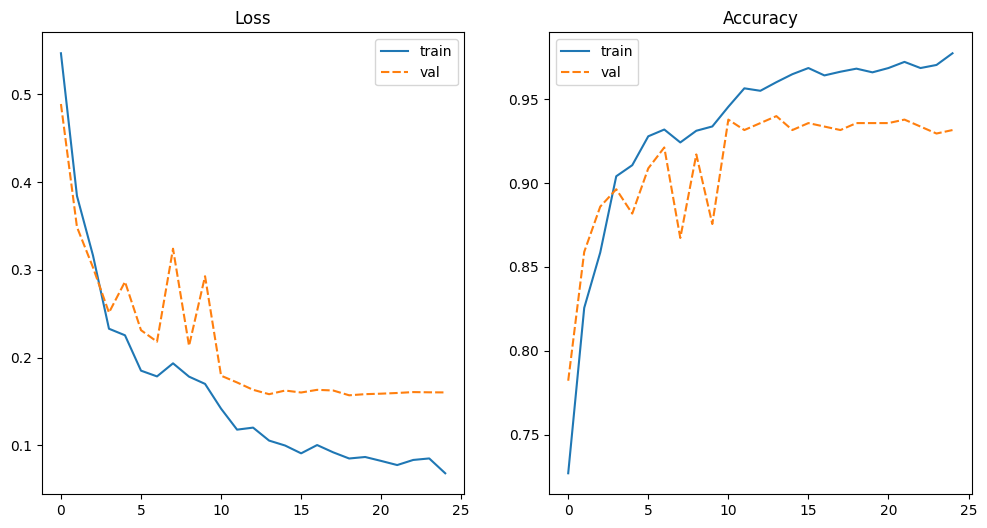

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.lineplot(data = loss, ax = axes[0])
sns.lineplot(data = accuracy, ax = axes[1])
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

Такие пики на валидации, скорее всего, связаны с большим learning rate при обучении. Я использовал механизм lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1), который каждые 10 эпох уменьшает lr в 10 раз, на графиках можно заметить, когда срабатывает lr_scheduler


Посмотрим в каких картинках наша нейронная сеть ошибается, и в каком классе

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def flatten(xss):
    return [x for xs in xss for x in xs]

y_test = []
predictions = []
misclassified_data = []

for data, target, path in val_loader:
    data = data.to(DEVICE)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred = pred.view(data.size(0))
    
    y_test.append(target.cpu().numpy())
    predictions.append(pred.cpu().numpy())
    
    misclassified_indices = (pred.cpu() != target).nonzero()
    for idx in misclassified_indices:
        misclassified_data.append([path[idx], target[idx].item()])

# misclassified_data содержит данные, которые были неправильно классифицированы
    
y_test = flatten(y_test)
predictions = flatten(predictions)

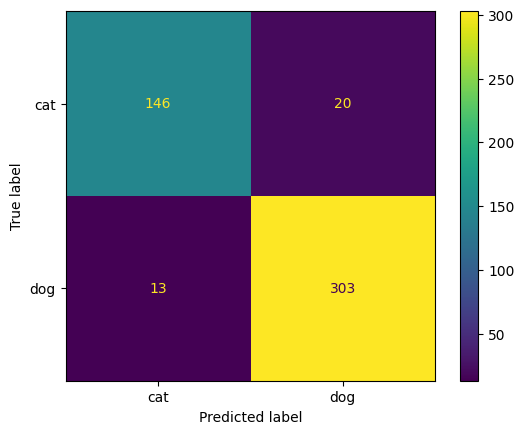

In [24]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm, display_labels=["cat", "dog"]).plot()

Сеть больше ошибается при классификации кошек (ну вприципе логично, т.к. их в датасете меньше и наша нейронная сеть ведела их меньше на обучении, чем собак)

Посмотрим конкретно на фотографии

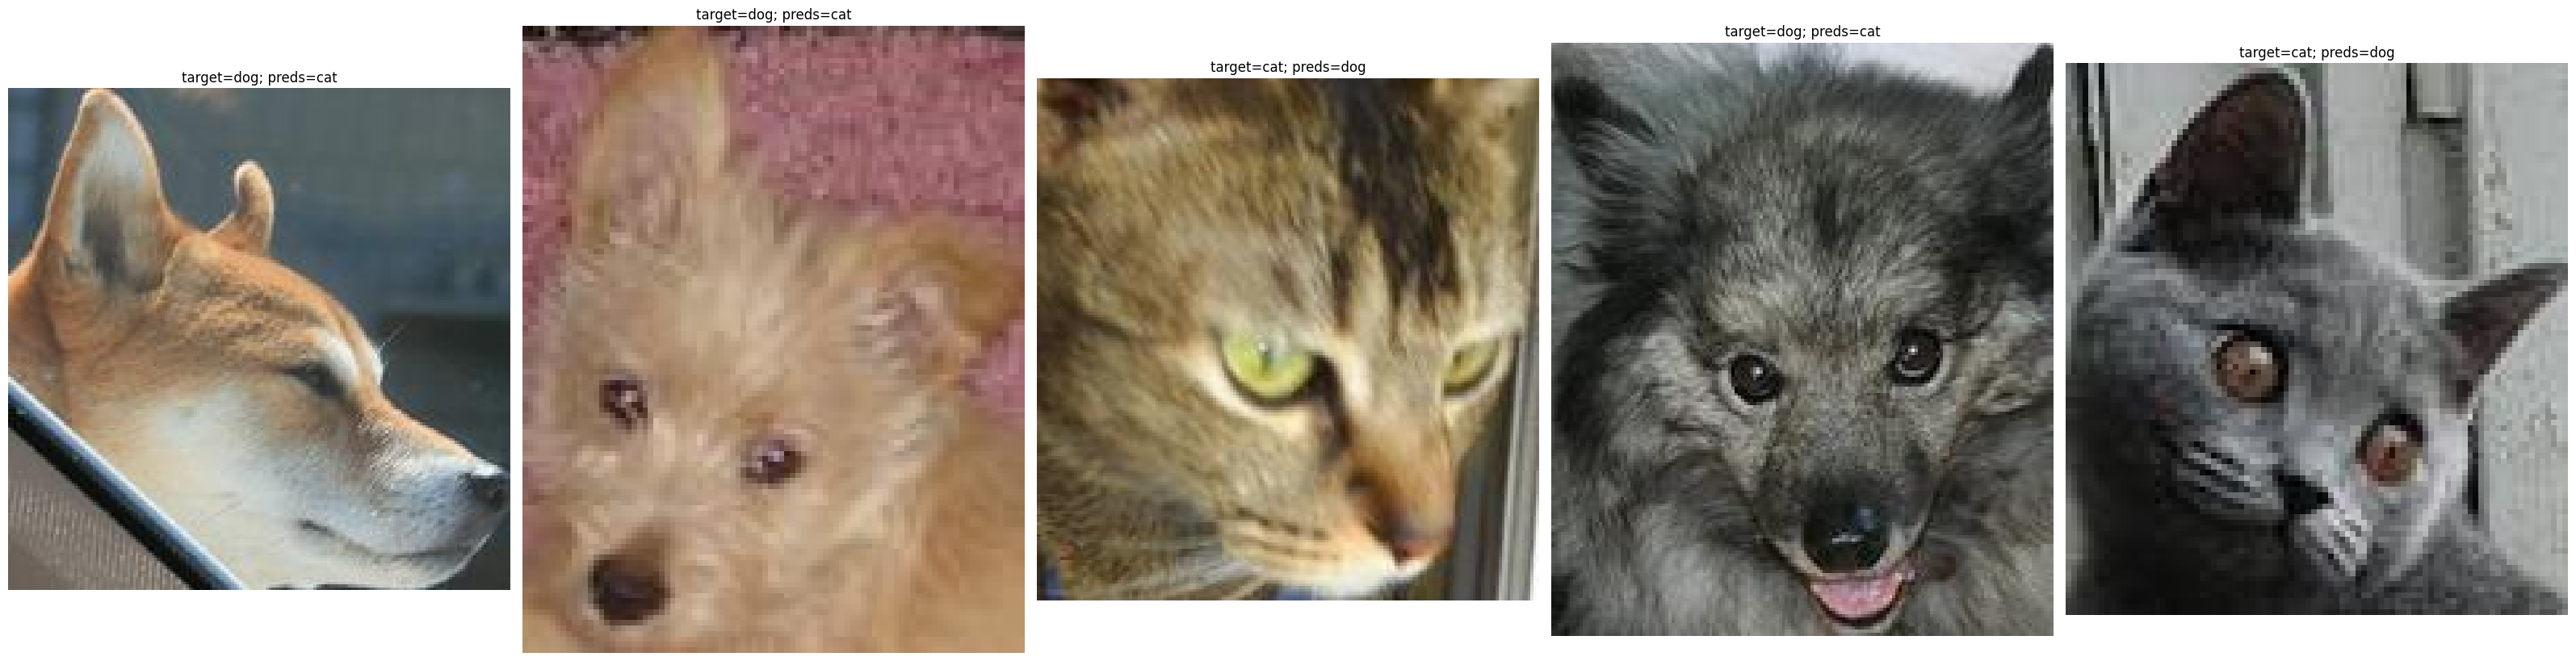

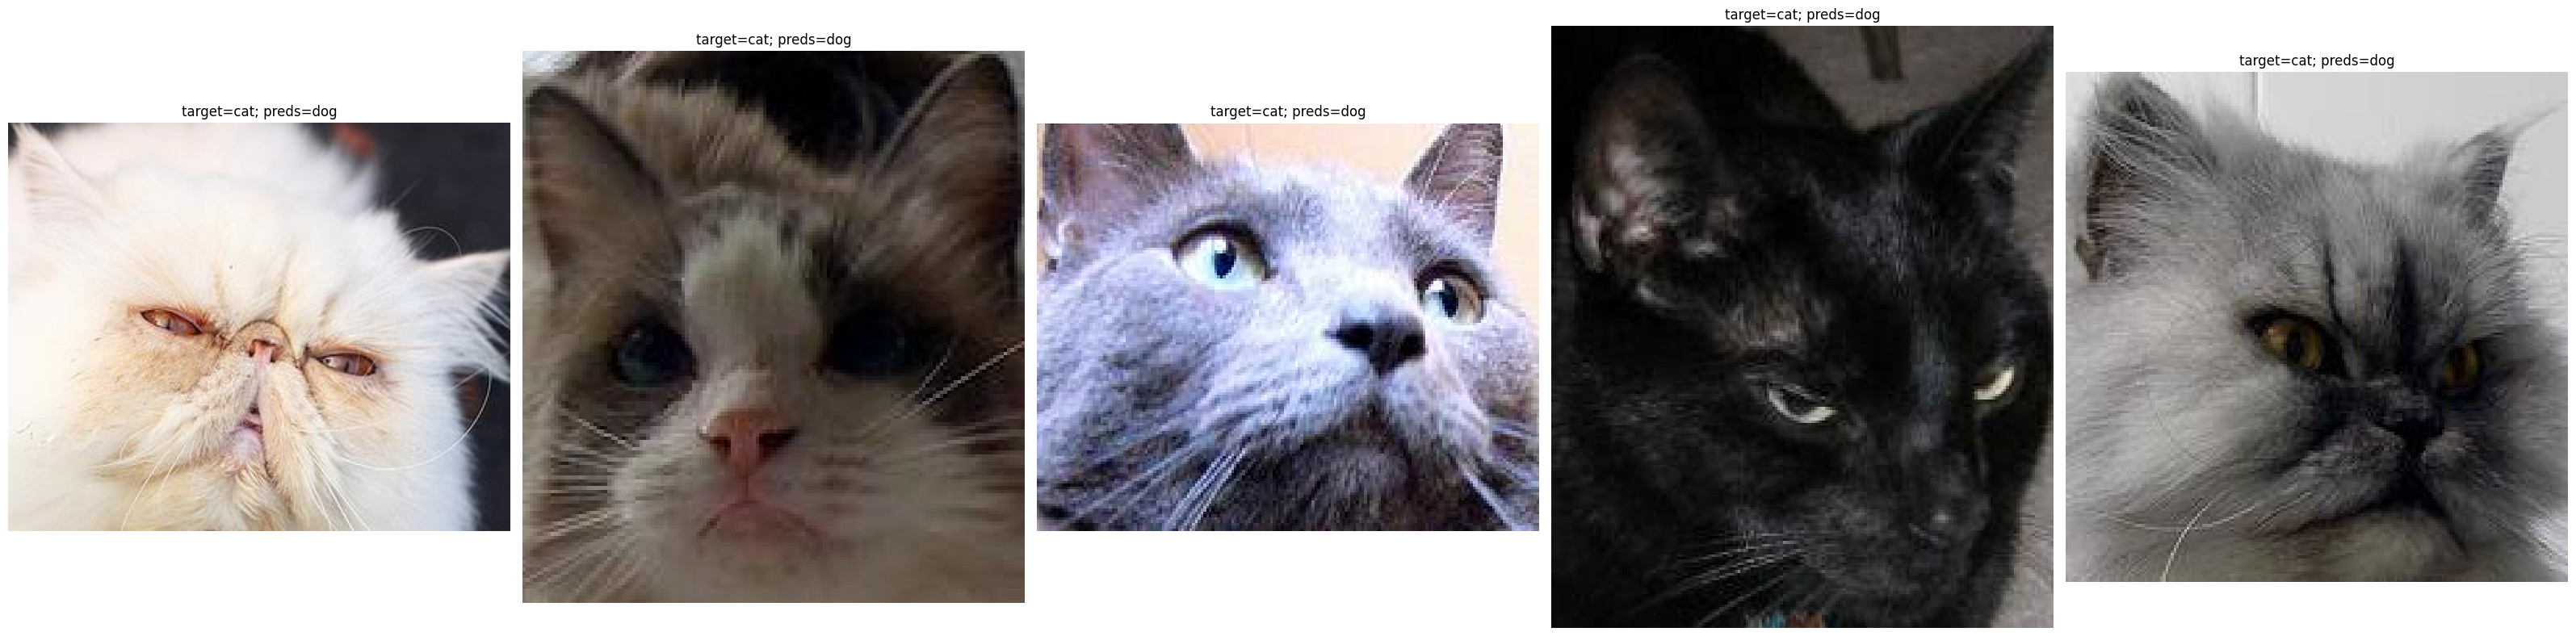

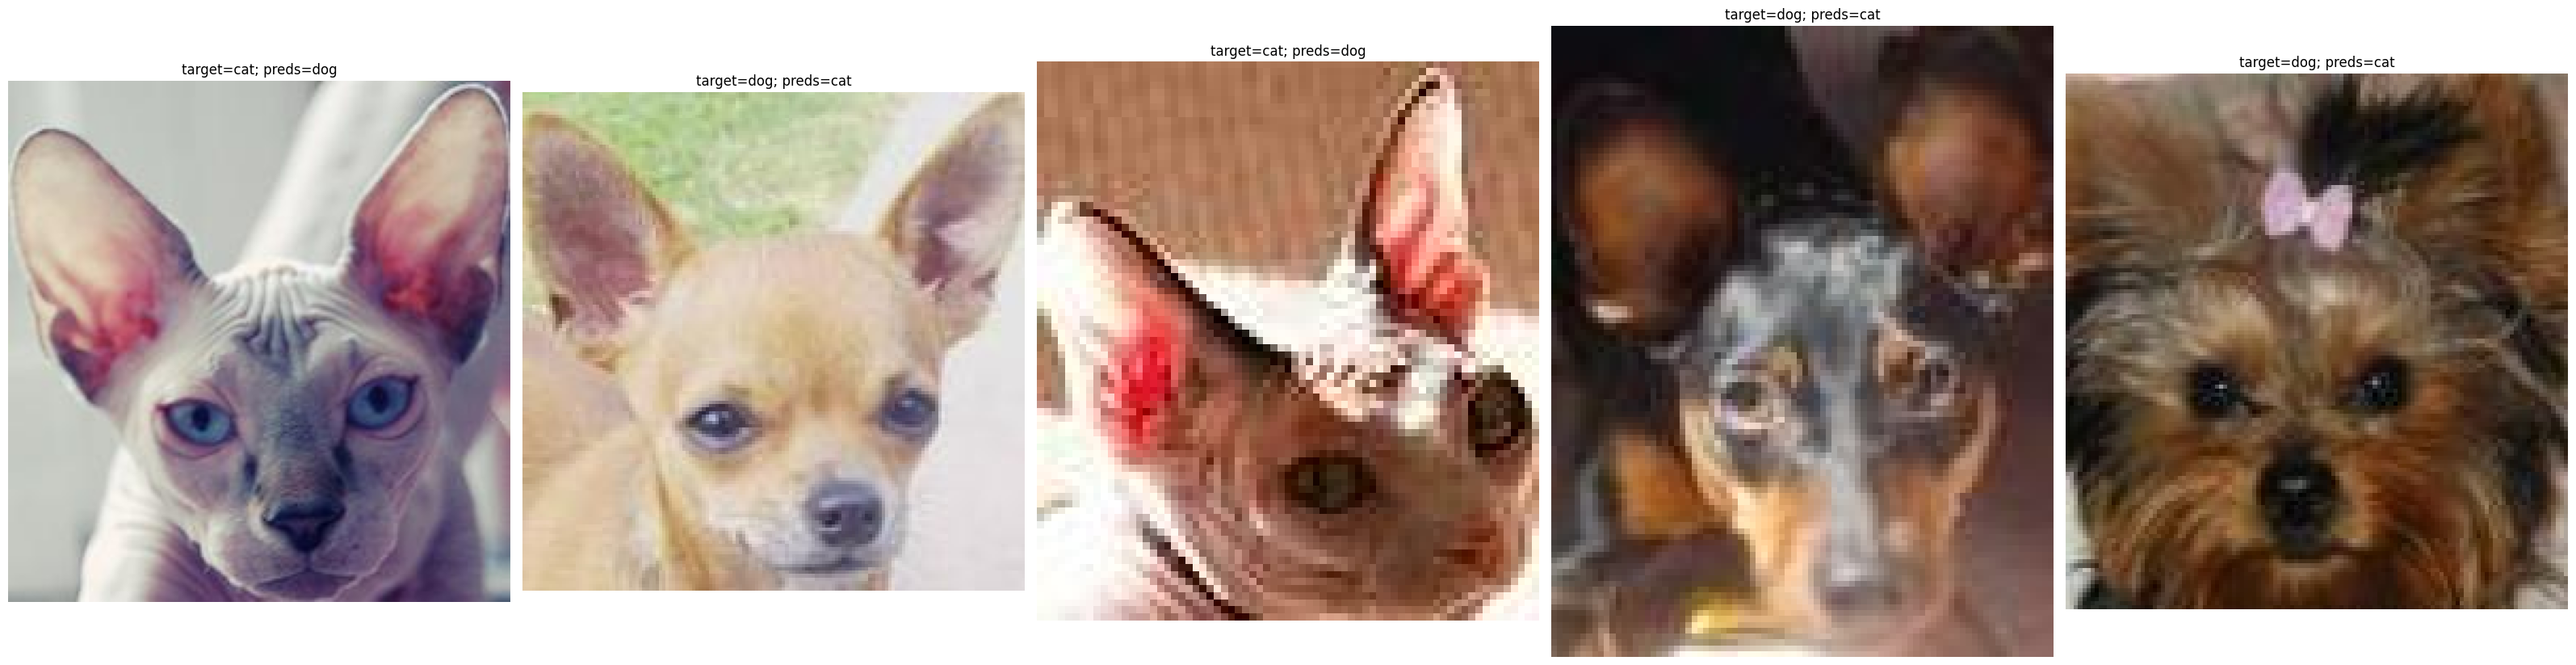

In [30]:
step = 5
start = 0
end = 5
N = 3
for i in range(N):
    sample = [misclassified_data[i][0] for i in range(start, end)]
    sample_targets = ["target=cat; preds=dog" if misclassified_data[i][1] == 0 else "target=dog; preds=cat" for i in range(start, end)]
    display_images(sample, sample_targets)
    start, end = end, end + step

In [99]:
import gc
torch.cuda.empty_cache()
gc.collect()

71

## Задача многоклассовой классификации

Усложним немного предыдущую модель

In [100]:
class CatDogNet2(nn.Module):
    def __init__(self, num_classes=2, hidden_dim = 8):
        super().__init__()

        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, kernel_size=7, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim,hidden_dim, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(),
            nn.Conv2d(hidden_dim*4, hidden_dim*4, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU(),
            nn.Conv2d(hidden_dim*8, hidden_dim*8, kernel_size=3, padding=1, stride = 2),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(hidden_dim*8, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        
        x = self.enc_conv0(x)
        x = self.enc_conv1(x)
        x = self.enc_conv2(x)
        x = self.enc_conv3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        x = self.classifier(x)

        return x

In [101]:
df_train, df_val = train_test_split(df, test_size = 0.15, stratify=df["form"])
print(df.shape)
print(df_train.shape)
print(df_val.shape)

train_data = DogCatDataset(df_train, target = "form", mode = "train")
val_data = DogCatDataset(df_val, target = "form", mode = "val")


train_loader = DataLoader(train_data, batch_size = 128, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 128)

(3211, 4)
(2729, 4)
(482, 4)


In [102]:
model = CatDogNet2(hidden_dim = 42, num_classes = len(list(df["form"].unique()))).to(DEVICE)
num_params = sum(p.numel() for p in model.parameters())
print(model)
print("\n Count parameters:", num_params)

CatDogNet2(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 42, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(42, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv1): Sequential(
    (0): Conv2d(42, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(84, 84, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv2): Sequential(
    (0): Con

In [103]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model, loss, accuracy = train(model, train_loader, val_loader, epochs = 25, optimizer = optimizer, sheduler = exp_lr_scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 001	 train_loss: 3.2988	     val_loss 3.1234	 train_acc 0.0986	 val_acc 0.1286

Epoch 002	 train_loss: 2.8136	     val_loss 2.7029	 train_acc 0.1990	 val_acc 0.2365

Epoch 003	 train_loss: 2.3153	     val_loss 2.5400	 train_acc 0.3342	 val_acc 0.2573

Epoch 004	 train_loss: 1.9222	     val_loss 1.9084	 train_acc 0.4262	 val_acc 0.4087

Epoch 005	 train_loss: 1.6054	     val_loss 2.1997	 train_acc 0.5119	 val_acc 0.3859

Epoch 006	 train_loss: 1.4059	     val_loss 1.7207	 train_acc 0.5713	 val_acc 0.4772

Epoch 007	 train_loss: 1.2315	     val_loss 1.4794	 train_acc 0.6152	 val_acc 0.5249

Epoch 008	 train_loss: 1.0840	     val_loss 1.3427	 train_acc 0.6654	 val_acc 0.5560

Epoch 009	 train_loss: 0.9573	     val_loss 1.3012	 train_acc 0.7017	 val_acc 0.5934

Epoch 010	 train_loss: 0.8888	     val_loss 1.1911	 train_acc 0.7230	 val_acc 0.6266

Epoch 011	 train_loss: 0.6996	     val_loss 0.9377	 train_acc 0.7834	 val_acc 0.7033

Epoch 012	 train_loss: 0.5934	     val_loss 0.8610	 t

Text(0.5, 1.0, 'Accuracy')

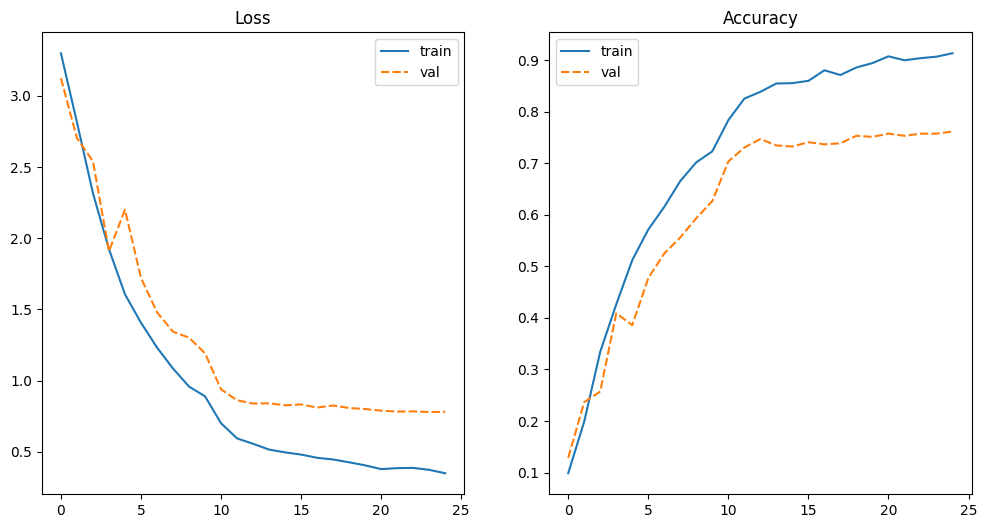

In [105]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.lineplot(data = loss, ax = axes[0])
sns.lineplot(data = accuracy, ax = axes[1])
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

Посмотрим в каких классах ошибается модель

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def flatten(xss):
    return [x for xs in xss for x in xs]

y_test = []
predictions = []
misclassified_data = []
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for data, target, path in val_loader:
    data = data.to(DEVICE)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred = pred.view(data.size(0))
    
    y_test.append(target.cpu().numpy())
    predictions.append(pred.cpu().numpy())
    
    misclassified_indices = (pred.cpu() != target).nonzero()
    for idx in misclassified_indices:
        misclassified_data.append([path[idx], label_encoder.classes_[pred[idx].item()]])

# misclassified_data содержит данные, которые были неправильно классифицированы
y_test = flatten(y_test)
predictions = flatten(predictions)

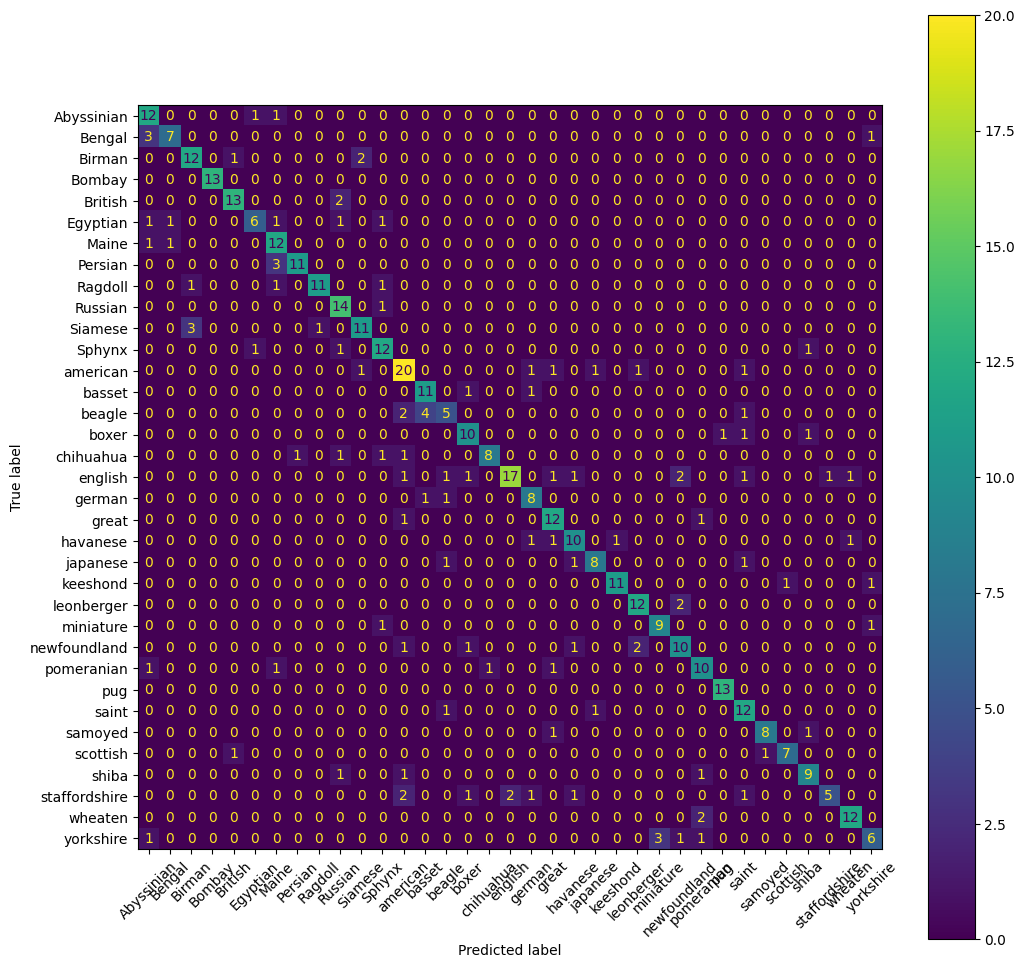

In [126]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize = (12, 12))
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(ax = ax)
plt.xticks(rotation = 45)
plt.show()

Посчитаем accuracy_top_3 и top_5

In [152]:
def accuracy_topk(output, target, topk=(1,)):
    """Вычисляет точность top-k для прогнозов output и целевых меток target."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        acc_list = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            acc_list.append(correct_k.mul_(100.0 / batch_size))
        return acc_list

top3_acc = []
top5_acc = []
for data, target, path in val_loader:
    data = data.to(DEVICE)
    output = model(data)
    top3, top5 = accuracy_topk(output.cpu(), target, topk=(3, 5))
    top3_acc.append(top3.item())
    top5_acc.append(top5.item())

print('Top-3 Accuracy:', np.mean(top3_acc), '%')
print('Top-5 Accuracy:',  np.mean(top5_acc), '%')

Top-3 Accuracy: 90.5691967010498 %
Top-5 Accuracy: 95.47990989685059 %
